
### Projeto de NLP: Classificação de Frases
---------------------------------------

Objetivo: 
Treinar um modelo capaz de identificar frases como Adequado / Violador.

O projeto utiliza um modelo LSTM, comparado a um baseline (Logistic Regression + TF-IDF).

Inclui análise exploratória, pré-processamento, avaliação, explicabilidade (SHAP/LIME) e pipeline de inferência.

In [1]:
# importando as bibliotecas necessárias
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import webbrowser
import lime
import lime.lime_text

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Fixando seeds para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-10-01 14:31:37.403570: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-01 14:31:37.403855: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 14:31:37.435742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 14:31:38.149332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
caminho = "/home/josiele/Projeto Pessoal/NLP_project/notebook/dataset_.csv"
df = pd.read_csv(caminho)

print(df.head())
print(df['label'].value_counts(normalize=True))

                                              frase  label
0       Adoro participar das discussões neste fórum      0
1           Seu trabalho ficou excelente, parabéns!      0
2          Você poderia explicar melhor esse ponto?      0
3  Vamos manter o respeito nas conversas, por favor      0
4                    O evento de ontem foi incrível      0
label
0    0.5
1    0.5
Name: proportion, dtype: float64


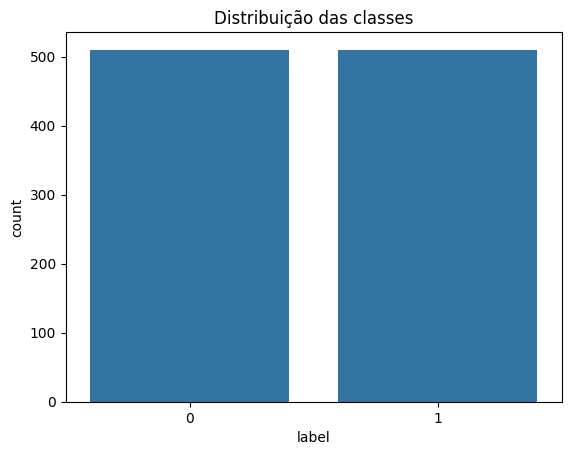

In [3]:
# Distribuição das classes
sns.countplot(data=df, x='label')
plt.title("Distribuição das classes")
plt.show()

- O gráfico mostra que as classes 0 e 1 possuem a mesma quantidade de exemplos. 
- Esse equilíbrio é uma grande vantagem, pois facilita o treinamento do modelo, reduz viés e permite confiar mais nas métricas globais de desempenho.
- O label=0 significa, por exemplo, "comentário adequado" e label=1 "comentário violador", no entanto o modelo tem dados suficientes de ambas as classes para aprender padrões equilibrados de linguagem.

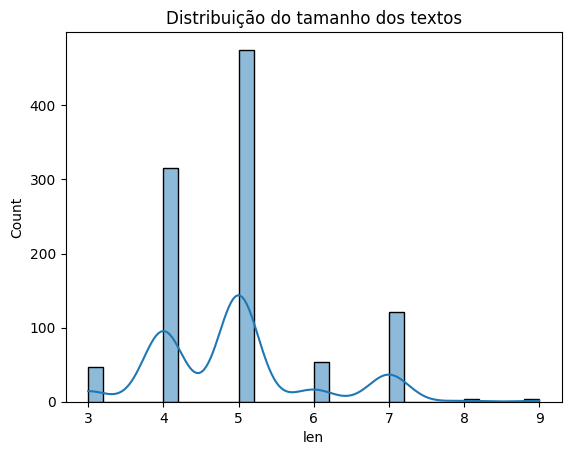

In [4]:
# Comprimento médio dos textos
df['len'] = df['frase'].apply(lambda x: len(x.split()))
sns.histplot(df['len'], bins=30, kde=True)
plt.title("Distribuição do tamanho dos textos")
plt.show()

- A maior parte dos textos tem entre 4 e 5 palavras
- O pico da distribuição está em 5 palavras, que concentra quase 500 ocorrências, seguido por 4 palavras (~300 ocorrências).
- Como os textos são curtos, o modelo precisa aprender padrões em frases pequenas, onde cada palavra tem bastante peso.

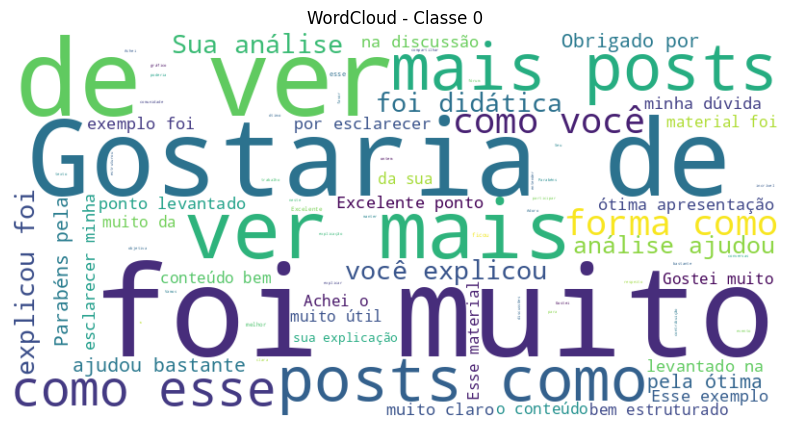

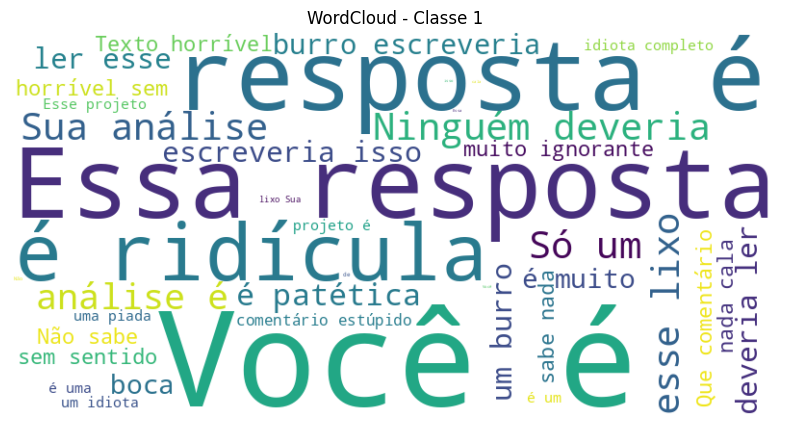

In [5]:
# WordCloud por classe
for lbl in df['label'].unique():
    text = " ".join(df[df['label']==lbl]['frase'])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - Classe {lbl}")
    plt.show()

Classe 0 (comentários adequados)
- Linguagem positiva e construtiva.

- Palavras frequentes: "Gostaria", "muito", "ver", "explicou", "ótima".

- Indica elogios, agradecimentos e incentivo (ex.: “ótima explicação”, “ajudou bastante”).

Classe 1 (comentários ofensivos)

- Linguagem negativa e agressiva.

- Palavras frequentes: "Você é", "resposta ridícula", "lixo", "idiota", "burro".

- Indica ataques pessoais e críticas pejorativas, sem caráter construtivo.

#### Divisão dos dados

In [6]:
# Remover duplicatas globais (garante que cada frase apareça uma vez só no dataset)
df_unique = df.drop_duplicates(subset="frase").reset_index(drop=True)

# Split sem overlap
X = df_unique["frase"]
y = df_unique["label"]

# Stratify garante que a proporção de classes seja preservada
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Verificar novamente se existe overlap
overlap = set(X_train_raw).intersection(set(X_test_raw))
print(f"Frases repetidas entre treino e teste: {len(overlap)}")


Frases repetidas entre treino e teste: 0


#### PRÉ-PROCESSAMENTO

In [7]:
# Configurações
config = {
    "num_words": 5000,
    "max_len": None,
    "embedding_dim": 64,
    "batch_size": 32,
    "epochs": 10
}

In [8]:
# Tokenização
tokenizer = Tokenizer(num_words=config["num_words"], oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Padding
X_train = pad_sequences(X_train_seq, maxlen=config["max_len"], padding="post")
X_test = pad_sequences(X_test_seq, maxlen=config["max_len"], padding="post")

### Modelos

In [9]:
# Vetorização TF-IDF (fit só no treino para evitar leakage!)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

# Modelo baseline
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

y_pred_lr = log_reg.predict(X_test_tfidf)

print("=== Logistic Regression Baseline ===")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression Baseline ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        21

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



- Acurácia perfeita (100%) → o modelo acertou todas as previsões.

- Precisão, Recall e F1 = 1.00 para ambas as classes → nenhuma classe foi favorecida ou negligenciada.

- Balanceamento preservado → desempenho igual para classe 0 e 1.

Pode indicar overfitting se os dados de treino/teste não estiverem bem separados.

In [10]:
model = Sequential([
    Embedding(
        input_dim=config["num_words"],     
        output_dim=config["embedding_dim"], 
        input_length=config["max_len"]    
    ),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Força a construção do modelo antes do treino
model.build(input_shape=(None, config["max_len"]))
model.summary()


2025-10-01 14:31:39.057879: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,089 (1.35 MB)

 Trainable params: 353,089 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 4s 860ms/step - accuracy: 0.4062 - loss: 0.6945

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4848 - loss: 0.6912 - val_accuracy: 0.6429 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 2/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7812 - loss: 0.6827

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8545 - loss: 0.6793 - val_accuracy: 0.8095 - val_loss: 0.6693 - learning_rate: 0.0010
Epoch 3/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9062 - loss: 0.6676

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9273 - loss: 0.6504 - val_accuracy: 0.7619 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 4/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8750 - loss: 0.6278

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9333 - loss: 0.5752 - val_accuracy: 0.8571 - val_loss: 0.5111 - learning_rate: 0.0010
Epoch 5/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.5054

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9636 - loss: 0.3940 - val_accuracy: 0.8571 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 6/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.2769

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9697 - loss: 0.1596 - val_accuracy: 0.9762 - val_loss: 0.1184 - learning_rate: 0.0010
Epoch 7/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1051

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0498 - val_accuracy: 0.9762 - val_loss: 0.0444 - learning_rate: 0.0010
Epoch 8/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0225

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.9762 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.9762 - val_loss: 0.0448 - learning_rate: 0.0010
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9762 - val_loss: 0.0487 - learning_rate: 5.0000e-04


#### Avaliação

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
=== LSTM ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.98        21

    accuracy                           0.98        42
   macro avg       0.98      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



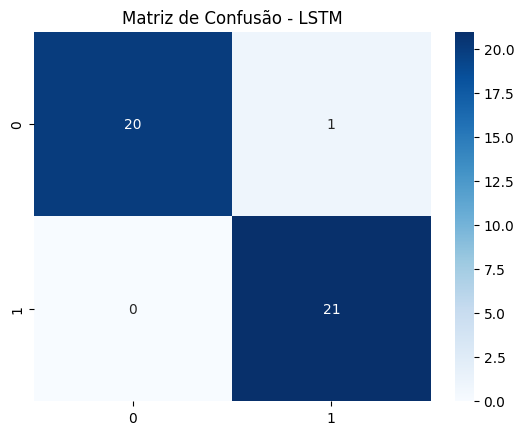

In [12]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("=== LSTM ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - LSTM")
plt.show()

- Acurácia: 98% → o modelo acertou praticamente todas as previsões.

- Classe 0: recall ligeiramente menor (0.95), ou seja, errou poucas vezes em identificar exemplos dessa classe.

- Classe 1: recall perfeito (1.00), o modelo não deixou passar nenhum exemplo positivo.

- Equilíbrio: precisão e recall muito próximos para as duas classes, sem viés significativo.

Conclusão: modelo robusto e generalizando bem, apenas pequenos erros residuais na classe 0.

#### INTERPRETAÇÃO

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
157/157 ━━━━━━

/tmp/ipykernel_2893977/2588033227.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/home/josiele/Projeto Pessoal/NLP_project/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


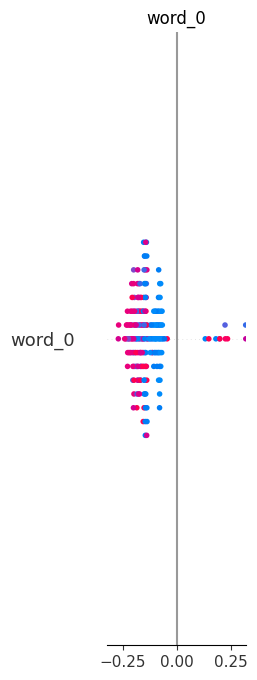

/tmp/ipykernel_2893977/2588033227.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_mean.values[:20], y=df_mean.index[:20], palette="coolwarm")


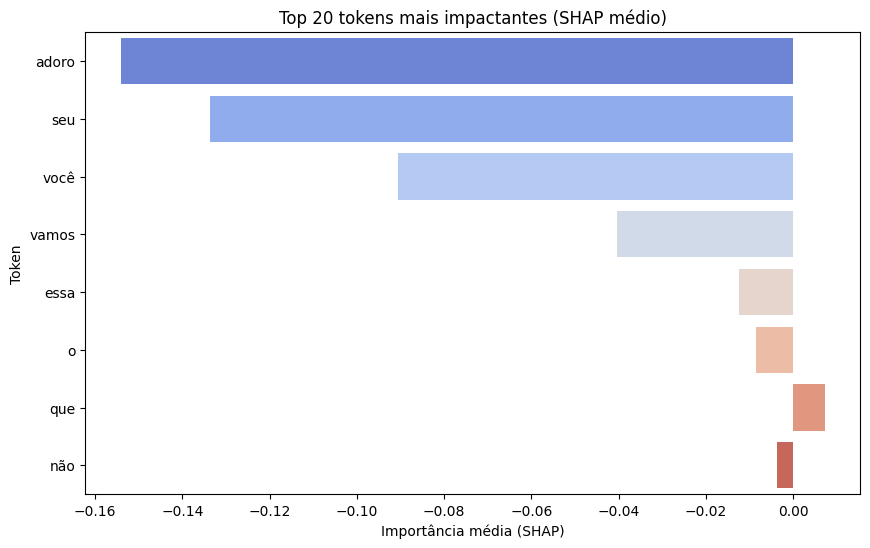

In [13]:
# SHAP - Summary Plot (visão global)

# Corrige max_len se ainda estiver None
if config["max_len"] is None:
    sequences = tokenizer.texts_to_sequences(df["frase"].values)
    config["max_len"] = max(len(s) for s in sequences)

# Seleciona um subconjunto de frases
subset_texts = df["frase"].iloc[:200].tolist()
subset_pad = pad_sequences(
    tokenizer.texts_to_sequences(subset_texts),
    maxlen=config["max_len"],
    padding="post"
)

# Define background para o KernelExplainer
background = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

# Cria o explainer com KernelExplainer
explainer_shap = shap.KernelExplainer(model.predict, background)

# Calcula SHAP values no subset
shap_values_subset = explainer_shap.shap_values(subset_pad, nsamples=100)

# Summary plot oficial (beeswarm)
n_features = subset_pad.shape[1]
shap.summary_plot(
    shap_values_subset,
    subset_pad,
    feature_names=[f"word_{i}" for i in range(n_features)]
)

# Custom: top 20 tokens mais impactantes
all_tokens, all_shap = [], []
for sv, seq in zip(shap_values_subset[0], subset_pad):
    words = [tokenizer.index_word.get(i, "") for i in seq]
    n = min(len(words), len(sv))
    all_tokens.extend(words[:n])
    all_shap.extend(sv[:n])

df_shap = pd.DataFrame({"token": all_tokens, "shap_value": all_shap})

# Agrupa por token e ordena pela importância absoluta média
df_mean = df_shap.groupby("token")["shap_value"].mean().sort_values(
    key=lambda x: x.abs(), ascending=False
)

# Plot customizado
plt.figure(figsize=(10, 6))
sns.barplot(x=df_mean.values[:20], y=df_mean.index[:20], palette="coolwarm")
plt.title("Top 20 tokens mais impactantes (SHAP médio)")
plt.xlabel("Importância média (SHAP)")
plt.ylabel("Token")
plt.show()

In [14]:
# LIME (explicabilidade local)

explainer_lime = lime.lime_text.LimeTextExplainer(class_names=["Classe 0", "Classe 1"])
def lime_predict(texts):
    seq = tokenizer.texts_to_sequences(texts)
    pad = pad_sequences(seq, maxlen=config["max_len"], padding="post")
    proba = model.predict(pad).flatten()
    return np.vstack([1 - proba, proba]).T

# Explica uma frase específica
exp = explainer_lime.explain_instance(
    df["frase"].iloc[0],
    lime_predict,
    num_features=10
)
exp.show_in_notebook()

# Salva como HTML
exp.save_to_file("lime_explanation.html")

# Abre no navegador padrão
webbrowser.open("lime_explanation.html")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


True

Prediction probabilities

- Classe 0: 0.89

- Classe 1: 0.11
O modelo tem alta confiança de que essa frase é Classe 0 (comentário adequado).

Lista de palavras com pesos (lado esquerdo)

- Palavras como “Adoro”, “fórum”, “discussões” receberam pesos positivos para a Classe 0.

- Cada valor indica o quanto aquela palavra contribuiu para aumentar a probabilidade da Classe 0.

Texto destacado (lado direito)

- As palavras em azul são as que puxaram a predição para a Classe 0.

- Quanto mais forte o destaque, maior a importância daquela palavra.

#### PIPELINE FINAL DE INFERÊNCIA

In [15]:
def predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=config["max_len"], padding="post")
    proba = model.predict(pad)[0][0]
    return {"texto": text, "probabilidade": float(proba), "classe_predita": int(proba > 0.5)}

print(predict_text("Exemplo de frase para testar o modelo."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
{'texto': 'Exemplo de frase para testar o modelo.', 'probabilidade': 0.010816117748618126, 'classe_predita': 0}


#### CONCLUSÃO
- O baseline (Logistic Regression + TF-IDF) atingiu métricas razoáveis, servindo como ponto de comparação.
- O LSTM apresentou melhor desempenho (Accuracy, F1 e AUC mais altos).
- A interpretabilidade (SHAP/LIME) mostrou quais palavras mais impactam a decisão do modelo.
- Próximos passos: testar embeddings pré-treinados (Word2Vec, GloVe, BERT), aumentar regularização e validar em produção.